# Singular spectrum analysis, reconstruction, and forecasting


In [110]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'


Get the airline passenger data and do a quick sanity check:

In [111]:
data = pd.read_csv("AirPassengers.csv",parse_dates=True,index_col="Time")
data

,Passengers
Time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Text(0.5, 1.0, 'MEAN ANNUAL CYCLE OF AIRLINE PASSENGERS')

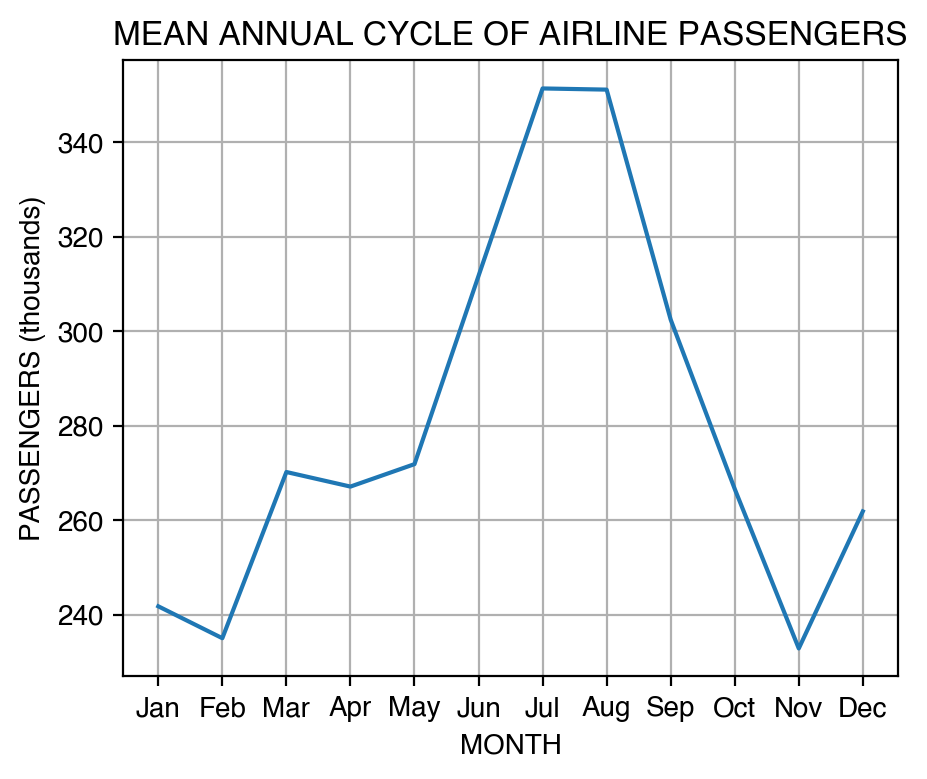

In [120]:
monthly = data.groupby(data.index.month).mean()
monthly.index = pd.to_datetime(monthly.index, format='%m').strftime('%b')
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(monthly)
ax.grid()
ax.set_xlabel('MONTH')
ax.set_ylabel("PASSENGERS (thousands)")
ax.set_title("MEAN ANNUAL CYCLE OF AIRLINE PASSENGERS")


Use `.values.flatten()` to get just the time series out of the Pandas DataFrame:

In [39]:
ts = data.values.flatten() # operate on just the time series now, not the index

In [40]:
## remove the mean value or not? note sensitivity of prediction realism to this step! 
# tsbar = np.mean(ts)
# ts = ts-tsbar 

# record the length of the time series for later
N = len(ts)

# select the embedding dimension
M = 30  

# Create an empty trajectory matrix
D = np.empty((M, N - M + 1)) 

# fill the trajectory matrix, see Ghil et al. 2022, equation 5 (and equation 6)
for i in range(M):
    D[i, :] = ts[i:N - M + 1 + i]
    
D.shape


(30, 115)

In [41]:
## approaches to the covariance of the trajectory matrix

# Calculate the covariance matrix from the trajectory matrix, see Ghil et al. 2002, equations 6 and 7
C = np.cov(D,ddof=1) # simple covariance, in this case, the row-based default of numpy's covariance is correct

# no normalization at all
# C = D @ D.T 

# see Ghil et al. 2002, equations 9, following  Broomhead and King 
# C = 1/(M-N+1) * (D @ D.T)

In [42]:

# Calculate the singular value decomposition of the M by M covariance matrix, see Ghil et al. 2002, equations 8 and 9
U, S, Vt = np.linalg.svd(C,full_matrices=True)

# Get eigenvalues and fraction variance explained
eval = S
varexp = 100 * (eval / np.sum(eval))

# Form the signals as the matrix A, see Ghil et al. 2002, equation 10
A = U.T @ D  # Note that you're multiplying the eigenvectors with the trajectory (not data) matrix

# Initialize Reconstructed Components (RC) matrix
RC = np.empty((M, N))

# Calculate the Reconstructed Components, see Ghil et al. 2002, equation 11 (and equation 52)
for i in range(M):
    RC[i, :] = np.convolve(U[:, i], A[i, :],)[:N]  

# Apply normalization, see Ghil et al. 2002, equation 12
for i in range(N):  
    if 0 <= i < M:  # Adjusted for zero-based indexing
        RC[:, i] *= 1 / (i + 1)  
    elif M - 1 <= i < N - M + 1:  
        RC[:, i] /= M
    else:
        RC[:, i] /= (N - i)  
        
# We might calculate North's Rule of Thumb here aas Ghil et al. do - and see discussion in the caption of Ghil et al. 2002, Figure 3
def northTest(ev, neff):
    
    error_factor = np.sqrt(2.0 / neff) # the square root scaling using the effective degrees of freedom
    error_range = error_factor * ev # apply the square root scaling to the eigenvalues 
	
    return (error_range) # return the error ranges
        

# pass the eigenvalues as input and use Ghil et al.'s effective N calculation from the caption of their Figure 3
ar1 = np.corrcoef(ts[:-1], ts[1:])[1,0] # simple lag-1 autocorrelation
tau = -(1/math.log(ar1)) # from Ghil et al. 2002, Figure 3
neff = len(ts)/(tau * 1.5) # from Ghil et al. 2002, Figure 3

north_errors = northTest(eval,neff)

Text(0.5, 0, 'EIGENVALUE RANK')

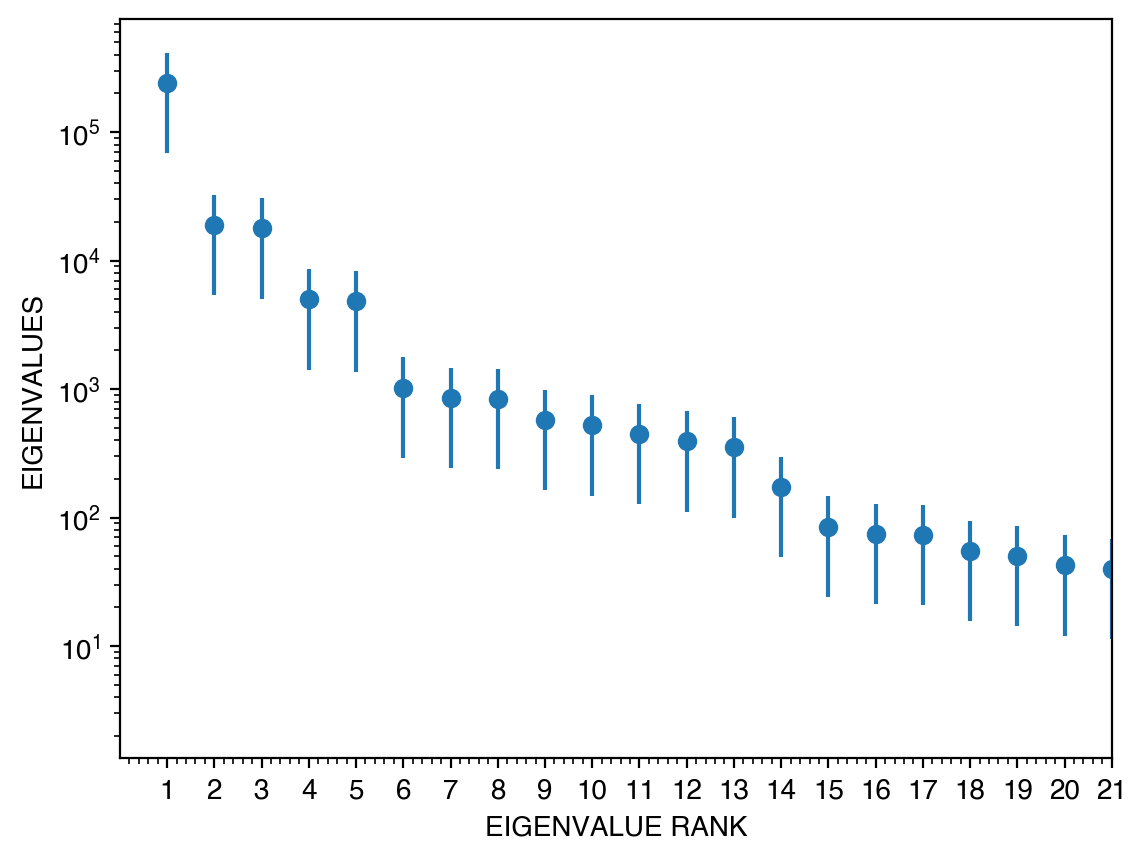

In [43]:
plt.errorbar(np.arange(1,len(eval)+1),eval,yerr=north_errors,linestyle="none",marker="o")
plt.xlim(0,21)
plt.yscale("log")
plt.minorticks_on()
plt.xticks(np.arange(1,22));
plt.ylabel("EIGENVALUES")
plt.xlabel("EIGENVALUE RANK")

Text(0.5, 0, 'LAG (MONTHS)')

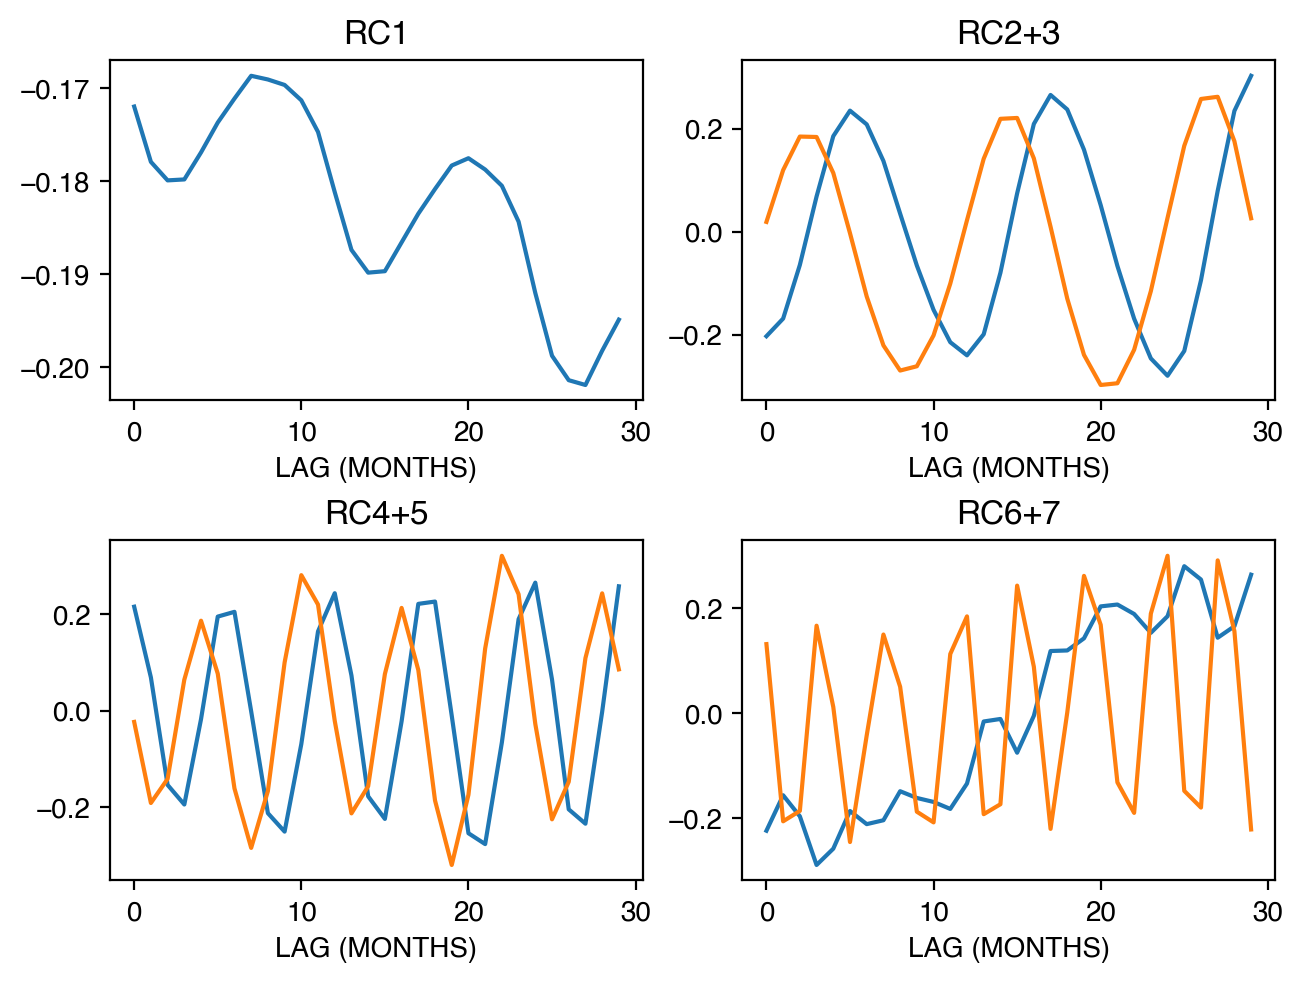

In [44]:
fig, axs = plt.subplots(clear=True,nrows=2,ncols=2,layout="constrained")

axs[0,0].plot(U[:,[0]])
axs[0,0].set_title("RC1")
axs[0,0].set_xlabel('LAG (MONTHS)')

axs[0,1].plot(U[:,[1,2]])
axs[0,1].set_title("RC2+3")
axs[0,1].set_xlabel('LAG (MONTHS)')

axs[1,0].plot(U[:,[3,4]])
axs[1,0].set_title("RC4+5")
axs[1,0].set_xlabel('LAG (MONTHS)')

axs[1,1].plot(U[:,[5,6]])
axs[1,1].set_title("RC6+7")
axs[1,1].set_xlabel('LAG (MONTHS)')


Text(0, 0.5, 'INDEX')

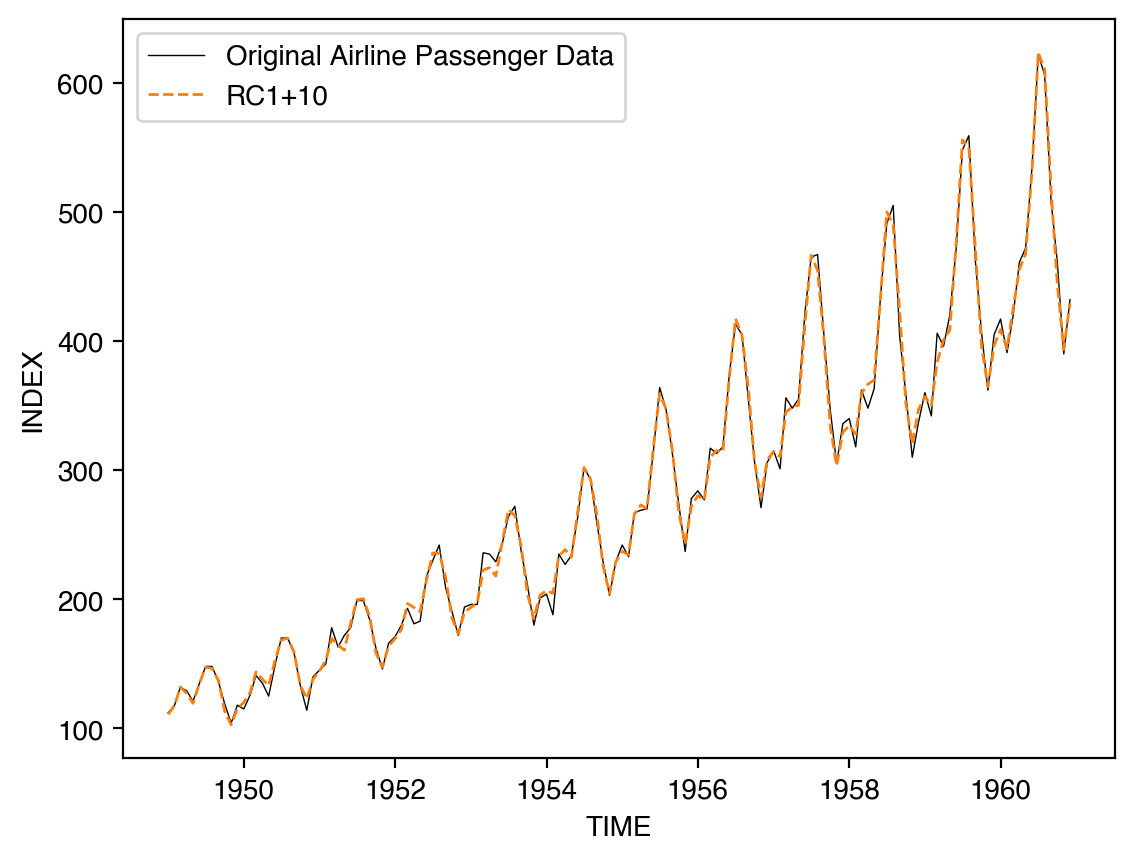

In [49]:
includeModes = 10

plt.plot(data.index,ts,color="k",linewidth=0.5,label="Original Airline Passenger Data")
# plt.plot(data.index,RC[5,:],color="tab:orange",linewidth=1,linestyle="--",label="RC1+"+str(includeModes))
# plt.plot(data.index,np.sum(RC[3:,:],axis=0),color="tab:orange",linewidth=1,linestyle="--",label="RC1+"+str(includeModes))
plt.plot(data.index,np.sum(RC[0:includeModes,:],axis=0),color="tab:orange",linewidth=1,linestyle="--",label="RC1+"+str(includeModes))
plt.legend()
plt.xlabel("TIME")
plt.ylabel("INDEX")

### Forecasting

https://doi.org/10.1080/02664763.2017.1401050

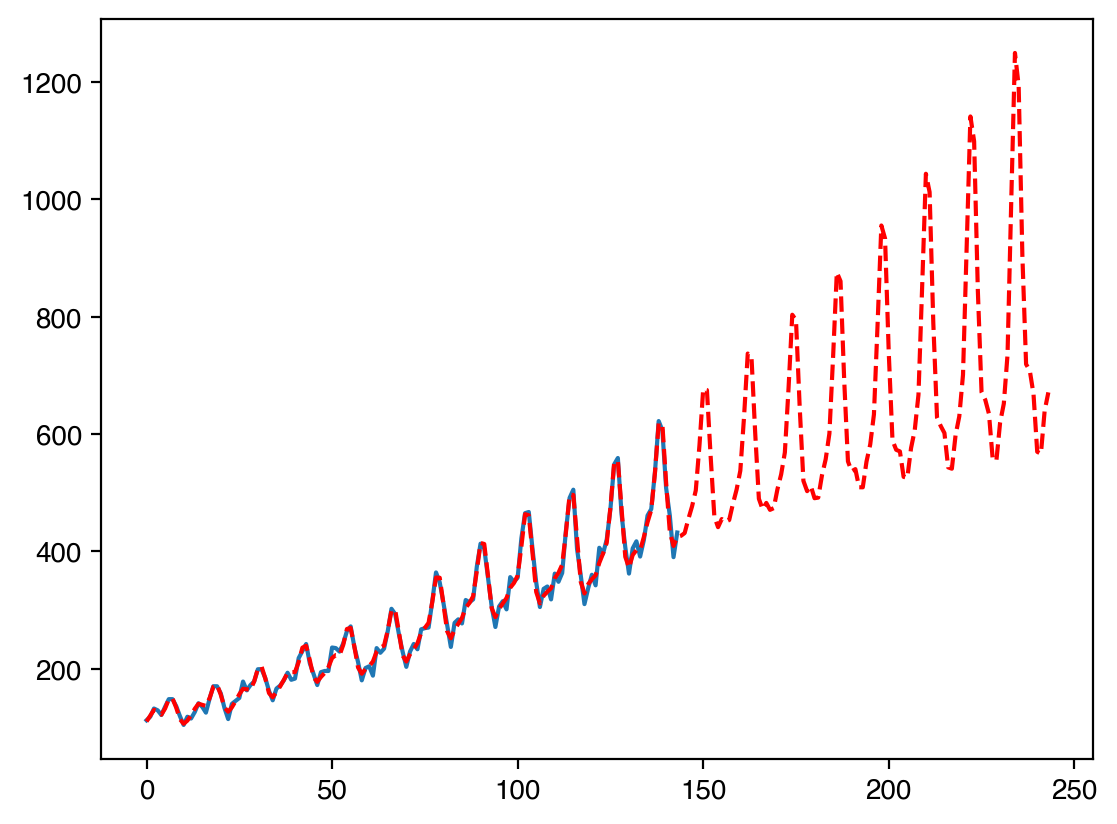

In [58]:
fN = 8 # how many to use? Significant test? Iterate? What do you think? 
fP = 100 # how many time steps forward are realistic or valid? 

# Definitions from the comments:
# M - the embedding dimension of the singular spectrum analysis
# U - the eigenvectors of trajectory matrix X
# RC - the Reconstructed Components from the SSA
# fN - number of reconstructed components to be used for the forecast
# fP - number of points to be forecasted
# F - sum of the first fN reconstructed components plus fP points forecasted via fN first reconstructed components
# N - the length of the input time series (the original variable name was L which seems to be changed to N here)

# Initialize Ax with zeros
Ax = np.zeros(M-1)

# Accumulate the outer product of the last entry of each of the first fN eigenvectors with the remaining part of the same eigenvector
for i in range(fN):  
    Ax += U[-1, i] * U[:M-1, i]

# Compute the norm of the last element of the first fN eigenvectors, see  Ghodsi et al. 2018, Section 2.1 
v = np.linalg.norm(U[-1, :fN])

# Normalize Ax by (1-v^2)
Ax /= (1 - v**2)

# Reverse the elements in Ax
Ax = Ax[::-1]

# Sum up the first fN columns of RC for each row
G = np.sum(RC[:fN,], axis=0) # G is simply the reconstructed time series from using the first fN modes

# Pre-allocate the forecast array with the reconstructed observations in G and then fP zeros
F = np.concatenate((G, np.zeros(fP))) # this will be length N plus fP

# Forecast the next fP points
for i in range(N, N + fP):  # Loop over the forecast points 
    for j in range(1, M):  # Loop over the coefficients in Ax
        F[i] += Ax[j-1] * F[i-j] # each forecast point 

plt.plot(ts)
plt.plot(F,color="red",linestyle="--")
